In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## Import Libraries

In [4]:
import os
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm
import numpy as np
import re
import tifffile as tiff
from matplotlib import pyplot
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, SpatialDropout2D
from tensorflow.keras import callbacks, layers, losses, metrics, models, optimizers, preprocessing, utils, regularizers, initializers
from tensorflow.keras.metrics import Precision, Recall, AUC, MeanIoU, F1Score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.models import Model
import keras_tuner as kt

In [5]:
def search_files(directory:str, pattern:str='.') -> list:
    '''Searches files in a directory'''
    files = list()
    for root, _, file_names in os.walk(directory):
        for file_name in file_names:
            files.append(os.path.join(root, file_name))
    files = list(filter(re.compile(pattern).search, files))
    files.sort()
    return files
    
def read_raster_tifffile(source: str, dtype: type = np.uint8) -> np.ndarray:
    '''Reads a raster as a numpy array using Tifffile'''
    try:
        img = tiff.imread(source).astype(dtype)
        # If it's single-channel, expand dimensions to match shape conventions
        if img.ndim == 2:  # Grayscale
            img = np.expand_dims(img, axis=-1)
        return img
    except Exception as e:
        print(f"Error reading file {source}: {e}")
        return None  # Return None if there's an error
        
def compare(images:list, titles:list=['']) -> None:
    '''Displays multiple images'''
    nimage = len(images)
    if len(titles) == 1:
        titles = titles * nimage
    fig, axs = pyplot.subplots(nrows=1, ncols=nimage, figsize=(5, 5*nimage))
    for ax, image, title in zip(axs.ravel(), images, titles):
        ax.imshow(image, cmap='gray')
        ax.set_title(title, fontsize=15)
        ax.set_axis_off()
    pyplot.tight_layout()
    pyplot.show()

def calculate_class_distribution(labels):
    positive_pixels = np.sum(labels)
    total_pixels = labels.size
    negative_pixels = total_pixels - positive_pixels
    return positive_pixels, negative_pixels

def plot_class_distribution(train_dist, val_dist, test_dist):
    labels = ['Train', 'Validation', 'Test']
    positive_counts = [train_dist[0], val_dist[0], test_dist[0]]
    negative_counts = [train_dist[1], val_dist[1], test_dist[1]]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = pyplot.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, positive_counts, width, label='Positive Pixels')
    rects2 = ax.bar(x + width/2, negative_counts, width, label='Negative Pixels')

    ax.set_xlabel('Dataset')
    ax.set_ylabel('Number of Pixels')
    ax.set_title('Class Distribution in Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    pyplot.show()

def display_history(history:dict, metrics:list=['accuracy', 'loss']) -> None:
    '''Displays training history'''
    fig, axs = pyplot.subplots(nrows=1, ncols=2, figsize=(10, 5))
    for ax, metric in zip(axs.ravel(), metrics):
        ax.plot(history[metric])
        ax.plot(history[f'val_{metric}'])
        ax.set_title(f'Training {metric}', fontsize=15)
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(['Training sample', 'Validation sample'], frameon=False)
    pyplot.tight_layout()
    pyplot.show()

def dice_metric(y_true, y_pred):
    """Calculate Dice Coefficient for ground truth and predicted masks."""
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions at 0.5
    intersection = tf.reduce_sum(y_true * y_pred)
    total_sum = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = tf.math.divide_no_nan(2 * intersection, total_sum)  # Avoid division by zero
    return dice


def iou_metric(y_true, y_pred):
    """Calculate IoU for ground truth and predicted masks."""
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Threshold predictions at 0.5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = tf.math.divide_no_nan(intersection, union)  # Avoid division by zero
    return iou

def weighted_binary_crossentropy(weights):
    def loss(y_true, y_pred):
        # Ensure y_true and y_pred have the same shape
        y_true = tf.expand_dims(y_true, axis=-1)  # Add a channel dimension to y_true if missing
        weight_map = y_true * weights[1] + (1 - y_true) * weights[0]
        return tf.keras.losses.binary_crossentropy(y_true, y_pred) * weight_map
    return loss

def custom_weighted_loss(y_true, y_pred):
    # Define the positive weight (you can calculate it based on class imbalance)
    pos_weight = 8.7  # Example: Weight for positive class
    # Use tf.nn.weighted_cross_entropy_with_logits
    loss = tf.nn.weighted_cross_entropy_with_logits(
        labels=y_true,
        logits=y_pred,
        pos_weight=pos_weight
    )
    return tf.reduce_mean(loss)

def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

In [6]:
def load_data(files):
    data_list = []
    for file in files:
        data = read_raster_tifffile(file)
        if data is not None:
            data_list.append(data)
    return np.array(data_list)

In [7]:
# Defines paths
paths = dict(
    images_train= '/kaggle/input/massachusetts-building-footprints-dataset/training/images',
    labels_train= '/kaggle/input/massachusetts-building-footprints-dataset/training/labels',
    images_valid= '/kaggle/input/massachusetts-building-footprints-dataset/validation/images',
    labels_valid= '/kaggle/input/massachusetts-building-footprints-dataset/validation/labels',
    images_test= '/kaggle/input/massachusetts-building-footprints-dataset/test/images',
    labels_test= '/kaggle/input/massachusetts-building-footprints-dataset/test/labels'
)

#load image and label files
image_train_files = search_files(paths['images_train'], '.*\.tif$')
label_train_files = search_files(paths['labels_train'], '.*\.tif$')
image_valid_files = search_files(paths['images_valid'], '.*\.tif$')
label_valid_files = search_files(paths['labels_valid'], '.*\.tif$')


#sort files in the same order
image_train_files.sort()
label_train_files.sort()
image_valid_files.sort()
label_valid_files.sort()

#load images and labels
train_images = load_data(image_train_files)
train_labels = load_data(label_train_files)
val_images = load_data(image_valid_files)
val_labels = load_data(label_valid_files)

In [8]:
#normalize images to range [0, 1]
train_images = train_images.astype(np.float32) / 255.0
val_images = val_images.astype(np.float32) / 255.0

# Set labels data type to float
train_labels = train_labels.astype(np.float32)
val_labels = val_labels.astype(np.float32)

Train Images Shape: (2343, 256, 256, 3)
Train Labels Shape: (2343, 256, 256, 1)
Validation Images Shape: (502, 256, 256, 3)
Validation Labels Shape: (502, 256, 256, 1)


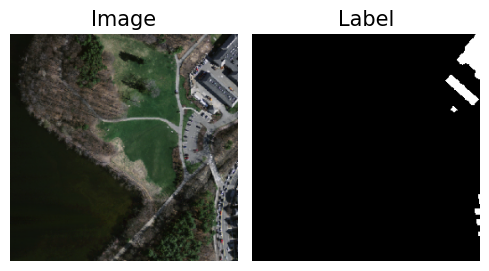

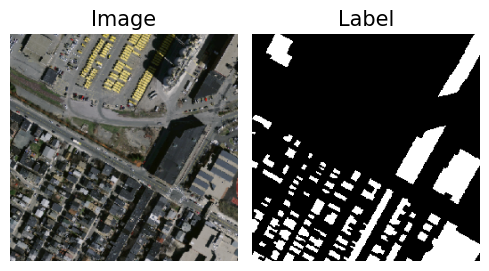

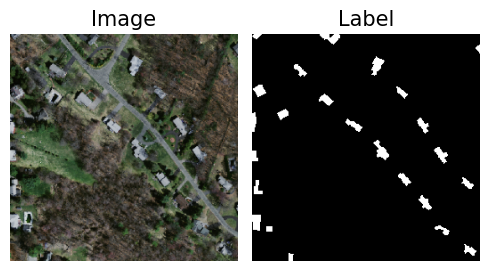

In [6]:
# check dimensions
print('Train Images Shape:', train_images.shape)
print('Train Labels Shape:', train_labels.shape)
print('Validation Images Shape:', val_images.shape)
print('Validation Labels Shape:', val_labels.shape)

# display several matching image and label pairs
n_samples = 3
sample_indices = np.random.choice(train_images.shape[0], n_samples, replace=False)

for idx in sample_indices:
    compare([train_images[idx], train_labels[idx]], titles=['Image', 'Label'])

## Plot the class distribution

In [7]:
image_test_files = search_files(paths['images_test'], '.*\.tif$')
label_test_files = search_files(paths['labels_test'], '.*\.tif$')

image_test_files.sort()
label_test_files.sort()

test_images = load_data(image_test_files)
test_labels = load_data(label_test_files)

test_images = test_images.astype(np.float32) / 255.0
test_labels = test_labels.astype(np.float32)

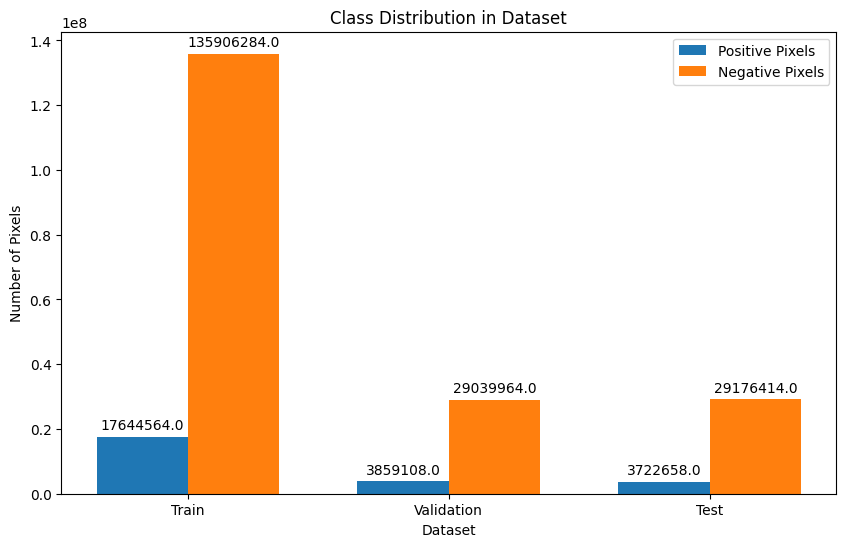

In [8]:
# Calculate class distribution for training, validation, and test labels
train_positive, train_negative = calculate_class_distribution(train_labels)
val_positive, val_negative = calculate_class_distribution(val_labels)
test_positive, test_negative = calculate_class_distribution(test_labels)


# Plot class distribution
train_dist = (train_positive, train_negative)
val_dist = (val_positive, val_negative)
test_dist = (test_positive, test_negative)

plot_class_distribution(train_dist, val_dist, test_dist)

## Model Architecture: Simple U-net:
Using the Keras functional API, define a simplified U-Net model with the number of kernels indicated in the figure above (i.e. 8, 16, 32, 64, 128, ...). There are numerous implementation examples of U-Nets using Keras. Choose the appropriate activation functions for the hidden layers and the output layer, and the corresponding parameter initialisation method.

## Build UNet Model

In [9]:
from tensorflow.keras.layers import UpSampling2D

# Encoder Block with SpatialDropout2D and Custom Kernel
def encoder_block(filters, inputs, dropout_rate=0.25, kernel_initializer='he_normal'):
    
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu',
               kernel_initializer=kernel_initializer)(inputs)
    x = SpatialDropout2D(dropout_rate)(x)  # Add spatial dropout
    s = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu',
               kernel_initializer=kernel_initializer)(x)
    s = SpatialDropout2D(dropout_rate)(s)  # Add spatial dropout
    p = MaxPooling2D(pool_size=(2, 2), padding='same')(s)
    return s, p  # p provides the input to the next encoder block, and s provides features for the decoder block

# Baseline Layer with SpatialDropout2D and Custom Kernel
def baseline_layer(filters, inputs, dropout_rate=0.25, kernel_initializer='he_normal'):
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu',
               kernel_initializer=kernel_initializer)(inputs)
    x = SpatialDropout2D(dropout_rate)(x)  # Add spatial dropout
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', strides=1, activation='relu',
               kernel_initializer=kernel_initializer)(x)
    x = SpatialDropout2D(dropout_rate)(x)  # Add spatial dropout
    return x

# Decoder Block with SpatialDropout2D and Custom Kernel
def decoder_block(filters, connections, inputs, dropout_rate=0.25, kernel_initializer='he_normal'):
    x = Conv2DTranspose(filters, kernel_size=(2, 2), padding='same', activation='relu', strides=2,
                        kernel_initializer=kernel_initializer)(inputs)
    skip_connections = concatenate([x, connections], axis=-1)
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer)(skip_connections)
    x = SpatialDropout2D(dropout_rate)(x)  # Add spatial dropout
    x = Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu',
               kernel_initializer=kernel_initializer)(x)
    x = SpatialDropout2D(dropout_rate)(x)  # Add spatial dropout
    return x


In [10]:
def unet():
  #Defining the input layer and specifying the shape of the images
  inputs = Input(shape = (256, 256, 3))

  #defining the encoder
  s1, p1 = encoder_block(32, inputs = inputs)
  s2, p2 = encoder_block(64, inputs = p1)
  s3, p3 = encoder_block(128, inputs = p2)
  s4, p4 = encoder_block(256, inputs = p3)

  #Setting up the baseline
  baseline = baseline_layer(512, p4)

  #Defining the entire decoder
  d1 = decoder_block(256, s4, baseline)
  d2 = decoder_block(128, s3, d1)
  d3 = decoder_block(64, s2, d2)
  d4 = decoder_block(32, s1, d3)

  #Setting up the output function for binary classification of pixels
  outputs = Conv2D(1, 1, activation = 'sigmoid')(d4)

  #Finalizing the model
  model = Model(inputs = inputs, outputs = outputs, name = 'Unet')

  return model

## Train and Run Model

In [11]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,  # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore weights from the best epoch
)

#initialize the model with batch normalization
unet_simp_sd_model = unet()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

unet_simp_sd_model.compile(
    optimizer=optimizer, 
    loss=combined_loss, 
    metrics=['accuracy', Precision(), Recall(), iou_metric, dice_metric]
)

#train
history = unet_simp_sd_model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    batch_size=8,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


I0000 00:00:1731891725.050234     137 service.cc:145] XLA service 0x7b6bdc003bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731891725.050353     137 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/293 ━━━━━━━━━━━━━━━━━━━━ 23s 81ms/step - accuracy: 0.6815 - dice_metric: 0.1280 - iou_metric: 0.0686 - loss: 1.6090 - precision: 0.0910 - recall: 0.2621   

I0000 00:00:1731891761.296056     137 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


293/293 ━━━━━━━━━━━━━━━━━━━━ 107s 216ms/step - accuracy: 0.8647 - dice_metric: 0.1216 - iou_metric: 0.0706 - loss: 1.2209 - precision: 0.2564 - recall: 0.1100 - val_accuracy: 0.8952 - val_dice_metric: 0.3075 - val_iou_metric: 0.1850 - val_loss: 0.9609 - val_precision: 0.6973 - val_recall: 0.1891
Epoch 2/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.8823 - dice_metric: 0.4515 - iou_metric: 0.2961 - loss: 0.9255 - precision: 0.5099 - recall: 0.4144 - val_accuracy: 0.9066 - val_dice_metric: 0.5833 - val_iou_metric: 0.4158 - val_loss: 0.7264 - val_precision: 0.6122 - val_recall: 0.5551
Epoch 3/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 82ms/step - accuracy: 0.9000 - dice_metric: 0.5424 - iou_metric: 0.3752 - loss: 0.8021 - precision: 0.5667 - recall: 0.5240 - val_accuracy: 0.9162 - val_dice_metric: 0.5968 - val_iou_metric: 0.4298 - val_loss: 0.7006 - val_precision: 0.6878 - val_recall: 0.5225
Epoch 4/50
293/293 ━━━━━━━━━━━━━━━━━━━━ 24s 81ms/step - accuracy: 0.9036 - dice_metric: 0.5

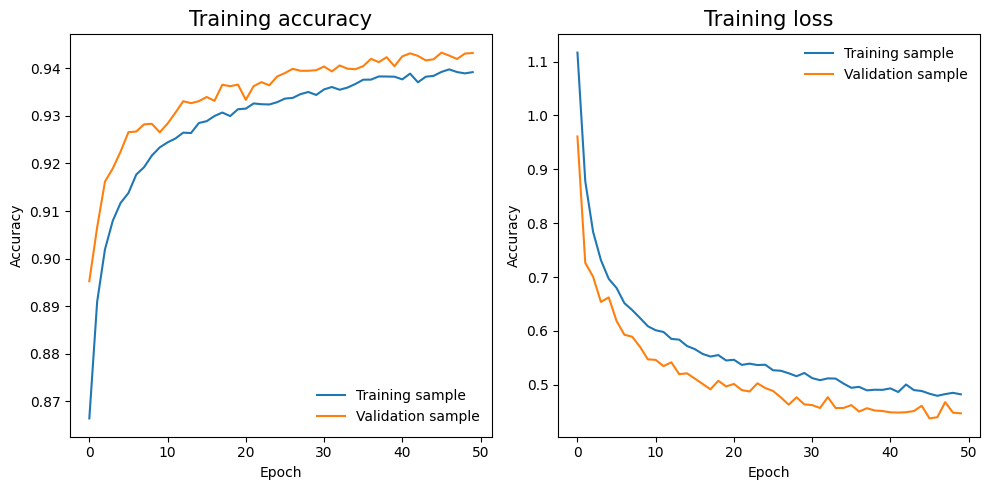

In [12]:
display_history(history.history, metrics=['accuracy', 'loss', 'dice_metric'])


## Run with Data Augmentation

In [11]:
def calculate_building_density(mask):
    return np.sum(mask) / mask.size  # Ratio of building pixels to total pixels

#calculate density for all masks
building_densities = [calculate_building_density(mask) for mask in train_labels]

threshold = 0.2  # Adjust threshold based on your dataset
images_to_augment = [img for img, density in zip(train_images, building_densities) if density > threshold]
masks_to_augment = [mask for mask, density in zip(train_labels, building_densities) if density > threshold]

In [12]:
import numpy as np
import albumentations as A

# Modify augmentation pipeline for images
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=30, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(p=0.1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # For images only
])

# Ensure masks are not normalized
def augment_image(image, mask):
    augmented = augmentation_pipeline(image=image, mask=mask)
    aug_img = augmented['image']
    aug_mask = augmented['mask']  # Keep mask unaltered
    return aug_img, aug_mask

# Lists to store augmented data
augmented_images = []
augmented_masks = []

# Apply augmentations and fix dimensions
for img, mask in zip(images_to_augment, masks_to_augment):
    aug_img, aug_mask = augment_image(img, mask)
    
    # Ensure image is in HWC format and has 3 channels
    if len(aug_img.shape) == 2:  # If grayscale
        aug_img = np.stack([aug_img] * 3, axis=-1)  # Convert to RGB by duplicating channels
    elif aug_img.shape[-1] == 1:  # If single channel
        aug_img = np.squeeze(aug_img, axis=-1)  # Remove single channel
        aug_img = np.stack([aug_img] * 3, axis=-1)  # Convert to RGB by duplicating channels

    # Ensure mask is in HWC format with 1 channel
    if len(aug_mask.shape) == 2:
        aug_mask = np.expand_dims(aug_mask, axis=-1)  # Add channel dimension
    
    augmented_images.append(aug_img)
    augmented_masks.append(aug_mask)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)

# Combine with original training data
final_train_images = np.concatenate([train_images, augmented_images], axis=0)
final_train_masks = np.concatenate([train_labels, augmented_masks], axis=0)


/opt/conda/lib/python3.10/site-packages/albumentations/check_version.py:49: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


In [14]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,  # Stop training if no improvement after 3 epochs
    restore_best_weights=True  # Restore weights from the best epoch
)

#initialize the model with batch normalization
unet_simp_sd_model = unet()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

unet_simp_sd_model.compile(
    optimizer=optimizer, 
    loss=combined_loss, 
    metrics=['accuracy', Precision(), Recall(), iou_metric, dice_metric]
)

#train
history = unet_simp_sd_model.fit(
    final_train_images, final_train_masks,
    validation_data=(val_images, val_labels),
    batch_size=8,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50


I0000 00:00:1731885122.432828    1900 service.cc:145] XLA service 0x7b44a402c5b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731885122.432894    1900 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/340 ━━━━━━━━━━━━━━━━━━━━ 27s 82ms/step - accuracy: 0.7861 - dice_metric: 0.0641 - iou_metric: 0.0331 - loss: 1.4281 - precision: 0.0721 - recall: 0.0611   

I0000 00:00:1731885159.147550    1900 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


340/340 ━━━━━━━━━━━━━━━━━━━━ 114s 204ms/step - accuracy: 0.8424 - dice_metric: 0.1000 - iou_metric: 0.0571 - loss: 1.2773 - precision: 0.2566 - recall: 0.0912 - val_accuracy: 0.8825 - val_dice_metric: 0.4125 - val_iou_metric: 0.2628 - val_loss: 0.9918 - val_precision: 0.4986 - val_recall: 0.3437
Epoch 2/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.8492 - dice_metric: 0.2953 - iou_metric: 0.1770 - loss: 1.0590 - precision: 0.4282 - recall: 0.2346 - val_accuracy: 0.9036 - val_dice_metric: 0.4918 - val_iou_metric: 0.3308 - val_loss: 0.8679 - val_precision: 0.6488 - val_recall: 0.3881
Epoch 3/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.8639 - dice_metric: 0.3984 - iou_metric: 0.2552 - loss: 0.9604 - precision: 0.5107 - recall: 0.3356 - val_accuracy: 0.9079 - val_dice_metric: 0.5832 - val_iou_metric: 0.4158 - val_loss: 0.7325 - val_precision: 0.6232 - val_recall: 0.5429
Epoch 4/50
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 82ms/step - accuracy: 0.8768 - dice_metric: 0.4